# Densenet

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as K
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
# from tensorflow.keras import datasets, layers, models

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import (Input, Conv2D,BatchNormalization, Concatenate,
                                    Activation, Add, MaxPooling2D, Dense, AveragePooling2D,
                                    GlobalAveragePooling2D)

from tensorflow.keras.layers import Dense, Flatten
from keras.applications import DenseNet121

2024-11-27 17:28:30.842754: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 17:28:30.913786: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732746510.955211  121794 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732746510.967730  121794 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 17:28:31.035392: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Preparation for trainning - Train Split

In [3]:
path = os.path.realpath('data/Dataset of Breast mammography images with Masses')
list_path = path.split('/')
list_path.remove('notebooks')
list_path.remove('breast-cancer-project')
path = os.path.join('/'.join(list_path), 'Image After Data Augmentation, Image Size 224x224/')

In [4]:
batch_size_n = 8

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(224, 224),
    batch_size=batch_size_n,
)

Found 7632 files belonging to 8 classes.
Using 6106 files for training.


I0000 00:00:1732746517.193181  121794 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1756 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
classes_ = train_ds.class_names
len(classes_)

8

In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(224, 224),
    batch_size=batch_size_n,
)

Found 7632 files belonging to 8 classes.
Using 1526 files for validation.


In [8]:
def normalize(image, label):
  return tf.cast(image/255., tf.float32), label

train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)

train_ds, val_ds

(<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

# Preparation for trainning - Test Split

In [9]:
path = os.path.realpath('data/Dataset of Breast mammography images with Masses')
list_path = path.split('/')
list_path.remove('notebooks')
list_path.remove('breast-cancer-project')
path = os.path.join('/'.join(list_path), 'Image Before Data Augmentation, Image Size 224x224/')

In [10]:
train_ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(224, 224),
    batch_size=batch_size_n,
)

Found 212 files belonging to 8 classes.
Using 170 files for training.


In [11]:
val_ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(224, 224),
    batch_size=batch_size_n,
)

Found 212 files belonging to 8 classes.
Using 42 files for validation.


In [12]:
def normalize(image, label):
  return tf.cast(image/255., tf.float32), label

train_ds_test = train_ds_test.map(normalize)
val_ds_test = val_ds_test.map(normalize)

train_ds_test, val_ds_test

(<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

# Training

In [13]:
from tensorflow.keras import mixed_precision


mixed_precision.set_global_policy('mixed_float16')

In [14]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

I0000 00:00:1732746518.426652  121794 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1756 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [15]:
with session.as_default():
    base_model = DenseNet121(weights=None, include_top=False, input_shape=(224, 224, 3), classes=8)
    x = base_model.output
    x = Flatten()(x)
    last_layer = Dense(8, activation='softmax')(x)

In [16]:
model = tf.keras.Model(inputs=base_model.input, outputs=last_layer)

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='SparseCategoricalCrossentropy',
              auto_scale_loss='False',
              metrics=['accuracy'])

In [18]:
epochs = 50
history = model.fit(train_ds,
                    validation_data=val_ds,
                    batch_size=batch_size_n,
                    epochs=epochs)

Epoch 1/50


I0000 00:00:1732746553.734978  121895 service.cc:148] XLA service 0x7f1984003ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732746553.735105  121895 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-11-27 17:29:14.663466: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732746562.153876  121895 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-27 17:30:53.520121: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 92 bytes spill stores, 92 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_138', 32 bytes spill stores, 32 bytes spill loads
ptxas warning : Registers are spilled to

741/764 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.2720 - loss: 6.2712

2024-11-27 17:33:13.732084: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_132', 84 bytes spill stores, 84 bytes spill loads



764/764 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.2722 - loss: 6.2239

2024-11-27 17:33:16.475870: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3641', 4 bytes spill stores, 4 bytes spill loads

2024-11-27 17:33:23.707163: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3641', 4 bytes spill stores, 4 bytes spill loads



764/764 ━━━━━━━━━━━━━━━━━━━━ 297s 213ms/step - accuracy: 0.2723 - loss: 6.2218 - val_accuracy: 0.2903 - val_loss: 1.7701
Epoch 2/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 56s 73ms/step - accuracy: 0.3135 - loss: 3.2823 - val_accuracy: 0.2615 - val_loss: nan
Epoch 3/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 57s 74ms/step - accuracy: 0.3127 - loss: 3.4107 - val_accuracy: 0.2969 - val_loss: nan
Epoch 4/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 57s 74ms/step - accuracy: 0.3710 - loss: 2.8862 - val_accuracy: 0.3827 - val_loss: 1.6211
Epoch 5/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 57s 75ms/step - accuracy: 0.3189 - loss: 3.3558 - val_accuracy: 0.2123 - val_loss: 8.3075
Epoch 6/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 56s 74ms/step - accuracy: 0.2774 - loss: 5.1472 - val_accuracy: 0.1822 - val_loss: nan
Epoch 7/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 57s 74ms/step - accuracy: 0.3414 - loss: 3.3083 - val_accuracy: 0.3801 - val_loss: 1.6905
Epoch 8/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 60s 79ms/step - accuracy: 0.3456 - loss: 2.9692 - val_accuracy: 0.27

# Evaluating

In [19]:
history.history

{'accuracy': [0.28169015049934387,
  0.303963303565979,
  0.33770063519477844,
  0.37995412945747375,
  0.30789387226104736,
  0.2885686159133911,
  0.34474286437034607,
  0.35194891691207886,
  0.37618735432624817,
  0.3553881347179413,
  0.33229610323905945,
  0.39338356256484985,
  0.40337371826171875,
  0.40615788102149963,
  0.40435636043548584,
  0.3635767996311188,
  0.3999345004558563,
  0.41254502534866333,
  0.40681296586990356,
  0.411726176738739,
  0.40239107608795166,
  0.4145103096961975,
  0.4135276675224304,
  0.43285292387008667,
  0.3991156220436096,
  0.428103506565094,
  0.4192597568035126,
  0.44480839371681213,
  0.4377661347389221,
  0.4235178530216217,
  0.41680315136909485,
  0.4423517882823944,
  0.4703570306301117,
  0.4911562502384186,
  0.49705207347869873,
  0.5145758390426636,
  0.5289878845214844,
  0.5489682555198669,
  0.5461840629577637,
  0.5748444199562073,
  0.5838519334793091,
  0.6103832125663757,
  0.6257779002189636,
  0.6537831425666809,
  0.

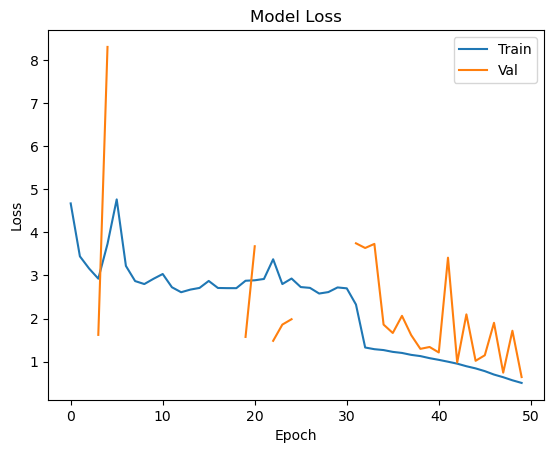

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

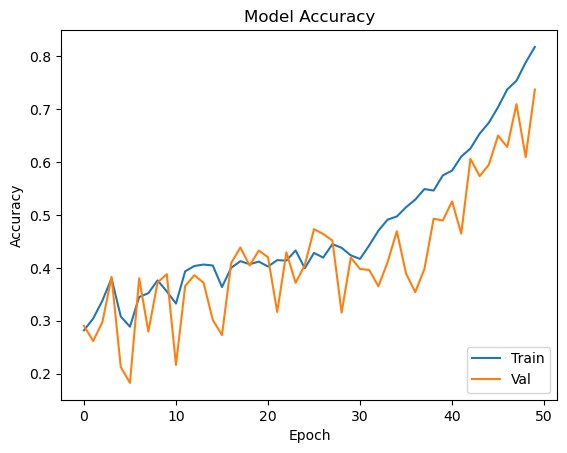

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [22]:
test_loss, test_acc = model.evaluate(val_ds, verbose=2)

191/191 - 3s - 16ms/step - accuracy: 0.7372 - loss: 0.6414


In [23]:
print(test_acc)

0.7372214794158936


In [24]:
predictions = model.predict(train_ds_test)
val_pred = np.argmax(predictions, axis=1)

2024-11-27 18:21:49.017467: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

2024-11-27 18:21:59.299734: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3624', 4 bytes spill stores, 4 bytes spill loads



22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step


In [25]:
y_true = []
y_pred = []
for images, labels in val_ds_test:
  # Make predictions on the batch
  batch_pred = model.predict(images)
  y_pred.extend(list(batch_pred.argmax(axis=1)))  # Predicted labels
  y_true.extend(list(labels.numpy()))  # True labels from the batch

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


2024-11-27 18:22:17.038040: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


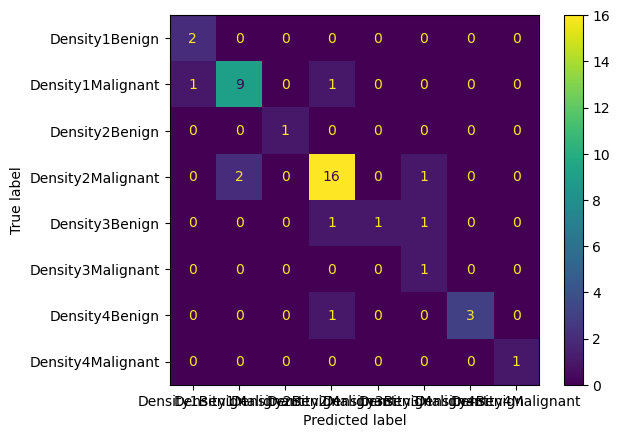

In [26]:
disp = ConfusionMatrixDisplay(cm, display_labels=classes_,)
disp.plot()

In [27]:
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.82      0.82      0.82        11
           2       1.00      1.00      1.00         1
           3       0.84      0.84      0.84        19
           4       1.00      0.33      0.50         3
           5       0.33      1.00      0.50         1
           6       1.00      0.75      0.86         4
           7       1.00      1.00      1.00         1

    accuracy                           0.81        42
   macro avg       0.83      0.84      0.79        42
weighted avg       0.85      0.81      0.81        42



# Save

In [28]:
# model.save('models/breast_cancer_classification-densenet.h5')